In [1]:
import itertools
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)
        
DEFAULT_FIGSIZE = (14, 7)

In [71]:
records = lidar.load_records(sync=True)

Unable to determine range 2
Unable to determine range 1


rider 3, trial 05, 593.691	593.700	0.009
rider 3, trial 06, 688.094	688.100	0.006


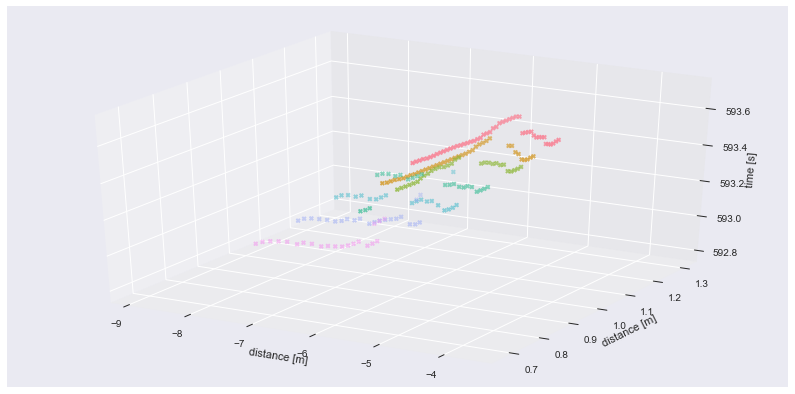

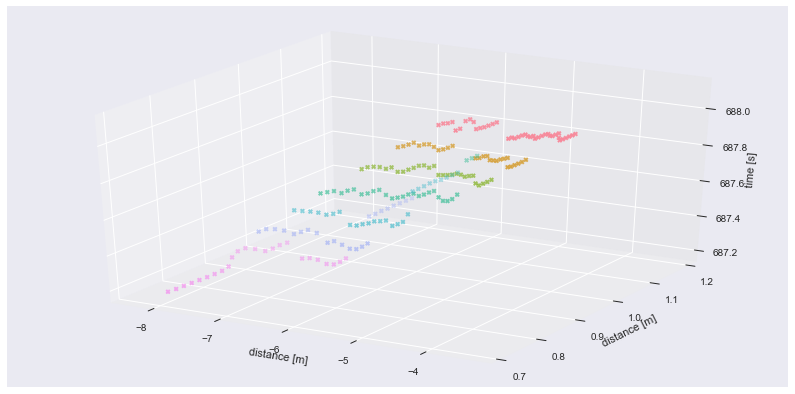

In [24]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

plt.close()
for rid, tid in itertools.product(range(3, 4), range(5, 7)):
    record = records[rid]
    trial = record.trial[tid]
    
    ev_time, ev_steer, ev = trial.steer_event_parameters()
    
    index0 = record.lidar.frame_index(ev_time[0])
    index = range(index0, index0 - 20, -3)
    
    xlim = (-15, -1)
    ylim = (-1, 3)
    x, y = record.lidar[index].cartesian(xlim=xlim,
                                         ylim=ylim)
    
    ## 3d plot
    z = np.concatenate(
        [t*np.ones(n) for t, n in zip(record.lidar[index].time,
                                      x.count(axis=1))])
    
    colors = sns.husl_palette(len(index), l=0.7)
    c = np.vstack(np.tile(colors[i], (n, 1))
                  for i, n in enumerate(x.count(axis=1)))
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE,
                           subplot_kw={'projection': '3d'})
    ax.scatter(x.compressed(), y.compressed(), z, c=c, marker='X')
    ax.set_xlabel('distance [m]')
    ax.set_ylabel('distance [m]')
    ax.set_zlabel('time [s]')
 
    ## 2d plot
    #fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    #colors = sns.husl_palette(len(index), l=0.7)
    #for i in range(len(index)):
    #    ax.plot(x[i, :], y[i, :], 'X',
    #            color=colors[i],
    #            label='frame {:0.03f} s'.format(record.lidar[index[i]].time))
    #ax.legend()
    #ax.set_xlabel('distance [m]')
    #ax.set_ylabel('distance [m]')
    #ax.set_title('LIDAR frame at time {:0.03f} (x:{}, y:{})'.format(
    #    record.lidar[index0].time, xlim, ylim))

    print('rider {}, trial {:02d}, {:0.03f}\t{:0.03f}\t{:0.03f}'.format(
        rid, tid, ev_time[0], record.lidar[index0].time,
        record.lidar[index0].time - ev_time[0]))
    
plt.show()

In [69]:
def animate_steer_event(rid, tid, xlim=None, ylim=None, speedup=1, **kwargs):
    record = records[rid]
    trial = record.trial[tid]
    ev_time, _, _ = trial.steer_event_parameters()
    
    t0 = ev_time[0] - 1
    t1 = ev_time[-1] + 1
    
    frames = record.lidar.frame(lambda t: (t >= t0) & (t < t1))
    
    c = sns.color_palette('Paired', 10)[1::2]
    colors = [c[2]
              if (t < ev_time[0]) or (t > ev_time[-1]) else c[1]
              for t in frames.time]
    
    if xlim is None:
        xlim = (-10, 5)
    if ylim is None:
        ylim = (-1, 3)
    return frames.animate(xlim, ylim, speedup, colors, **kwargs)

In [77]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    IPython.display.display(IPython.display.HTML(ani.to_html5_video()))
    
    
for rid, tid in itertools.product(range(4), range(15)):
    ani = animate_steer_event(rid, tid,
                              xlim=(-10, 3), ylim=(-1, 3),
                              speedup=0.5, figsize=(12, 8))
    ani._fig.get_axes()[0].set_title('rider {} trial {:02d}'.format(rid, tid))
    display_animation(ani)